In [1]:
import pickle

import jax.numpy as jnp
import numpy as np
import optax
import pandas as pd
from icot.data.dataloader import ConditionalLoader, PrecomputedCouplingDataset
from icot.models.models import ICOTClassifier
from icot.nets.nets import AttentionClassifier
from torch.utils.data import DataLoader
from tqdm import tqdm

2024-04-08 17:44:09.692457: W external/xla/xla/service/gpu/nvptx_compiler.cc:718] The NVIDIA driver's CUDA version is 12.3 which is older than the ptxas CUDA version (12.4.131). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
cfg = {"model": {"plan_size": ["all", "all"], "min_seq_length": 10, "max_seq_length": 200, "batch_size": 15}}

In [3]:
cfg

{'model': {'plan_size': ['all', 'all'],
  'min_seq_length': 10,
  'max_seq_length': 200,
  'batch_size': 15}}

In [21]:
import os

data_dir = "/lustre/groups/ml01/workspace/icot/sciplex/data/"
dataloaders = []
FILE_PREFIX = f"{0.01}_PLAN_SIZE_{"all"}_{"all"}_"
plan_it = 0
drugs = pd.read_csv("/lustre/groups/ml01/workspace/icot/sciplex/drugs_kept.csv")["perturbation"]
for i, drug in enumerate(drugs):
    file_prefix = f"{FILE_PREFIX}_{drug}_{plan_it}_"
    src = np.load(os.path.join(data_dir, file_prefix + "source.npy"))
    tgt = np.load(os.path.join(data_dir, file_prefix + "target.npy"))
    plan = np.load(os.path.join(data_dir, file_prefix + "plan.npy"))
    ds = PrecomputedCouplingDataset(i, [(src, tgt, plan)], 199, 200)
    dl = DataLoader(ds, batch_size=20, shuffle=True)
    dataloaders.append(dl)

In [22]:
cl = ConditionalLoader(dataloaders, seed=13)

In [38]:
TEST_FILE = os.path.join(data_dir, f"{FILE_PREFIX}_test_set.pkl")
with open(TEST_FILE, "rb") as f:
    loaded_dict = pickle.load(f)

In [76]:
FILE_PREFIX

'0.01_PLAN_SIZE_all_all_'

In [40]:
len(loaded_dict)

177

In [23]:
data_dim = src.shape[1] + tgt.shape[1]
num_classes = len(drugs)
opt = optax.MultiSteps(optax.adamw(1e-4), 5)

net = AttentionClassifier(num_heads=4, qkv_feature_dim=data_dim, output_dim=num_classes, hidden_dims=[512, 512])
model = ICOTClassifier(net=net, num_classes=num_classes, max_seq_length=200, data_dim=data_dim, optimizer=opt)

training_loss = []
training_accuracy = []
curr_loss = []
curr_acc = []
n_iters = 10000
valid_freq = 20000

In [24]:
from typing import List


def pad_dataset(dataset: List[jnp.ndarray], lengths: List[jnp.ndarray], max_seq_length: int, pad_token=0):
    padded_dataset = []
    attention_mask = []
    for data, length in zip(dataset, lengths):
        pad_length = max_seq_length - length
        padded_data = jnp.pad(data, ((0, pad_length), (0, 0)), constant_values=pad_token)
        padded_data = padded_data[:max_seq_length]
        padded_dataset.append(padded_data)
        mask = jnp.array([1] * int(length) + [0] * int(pad_length))  # 1 no pad, 0 pad
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.array(padded_dataset), jnp.array(attention_mask)

In [25]:
for it in tqdm(range(n_iters)):
    batch = next(cl)
    seq_lengths = [int(batch[1][ix][0]) for ix in range(len(batch[1]))]
    padded_dataset, attention_masks = pad_dataset(
        jnp.asarray(batch[0]), seq_lengths, max_seq_length=model.max_seq_length
    )

    batch_it = dict()
    batch_it["padded_data"] = jnp.array(padded_dataset)
    batch_it["labels"] = jnp.array(batch[2])
    batch_it["masks"] = jnp.asarray(attention_masks)

    model.net_state, train_metrics = model.step_fn(model.net_state, batch_it)

    if it == 0:
        continue
    elif it % valid_freq == 0:
        mean_loss = np.mean(curr_loss)
        mean_acc = np.mean(curr_acc)
        training_loss.append(mean_loss)
        training_accuracy.append(mean_acc)
        curr_loss = []
        curr_acc = []

        valid_accs = []
        valid_losses = []
        valid_accs_seq_length_min = []
        valid_accs_seq_length_max = []
        for drug in drugs:
            for seq_length in range(SEQUENCE_LENGTHS_TEST_MIN, SEQUENCE_LENGTHS_TEST_MAX + 1, STEP_SEQ_LENGTH):
                valid_batch = test_set[drug][seq_length]
                seq_lengths = [seq_length] * len(valid_batch)
                padded_dataset, attention_masks = pad_dataset(
                    jnp.asarray(valid_batch), seq_lengths, max_seq_length=model.max_seq_length
                )

                batch_it = dict()
                batch_it["padded_data"] = jnp.array(padded_dataset)
                batch_it["labels"] = jnp.array(valid_batch[2])
                batch_it["masks"] = jnp.asarray(attention_masks)
                _, valid_metrics = model.valid_step_fn(model.net_state, batch_it)
                valid_accs.append(valid_metrics["valid_acc"])
                valid_losses.append(valid_metrics["valid_loss"])

                if seq_length == cfg.test_set.SEQUENCE_LENGTHS_TEST_MIN:
                    valid_accs_seq_length_min.append(valid_metrics["valid_acc"])
                if seq_length == cfg.test_set.SEQUENCE_LENGTHS_TEST_MAX:
                    valid_accs_seq_length_max.append(valid_metrics["valid_acc"])

        mean_valid_acc = np.mean(np.array(valid_accs))
        mean_valid_loss = np.mean(np.array(valid_losses))
        mean_valid_acc_min_seq = np.mean(np.array(valid_accs_seq_length_min))
        mean_valid_acc_max_seq = np.mean(np.array(valid_accs_seq_length_max))
        # wandb.log({"train_acc": mean_acc,
        #           "train_loss": mean_loss,
        #           "valid_acc": mean_valid_acc,
        #           "valid_loss": mean_valid_loss,
        #           "valid_acc_min_seq": mean_valid_acc_min_seq,
        #           "valid_acc_max_seq": mean_valid_acc_max_seq})
    else:
        curr_loss.append(train_metrics["loss"])
        curr_acc.append(train_metrics["accuracy"])

100%|██████████| 10000/10000 [07:20<00:00, 22.71it/s]


In [43]:
test_set = loaded_dict

In [46]:
valid_batch.shape

(10, 50, 2000)

In [47]:
seq_lengths

[50, 50, 50, 50, 50, 50, 50, 50, 50, 50]

In [48]:
padded_dataset.shape

(10, 200, 2000)

In [64]:
df_drugs = pd.read_csv("/lustre/groups/ml01/workspace/icot/sciplex/drugs_kept.csv")

In [59]:
for _, row in df_drugs.iterrows():
    for seq_length in range(cfg.test_set.SEQUENCE_LENGTHS_TEST_MIN, cfg.test_set.SEQUENCE_LENGTHS_TEST_MAX):
        valid_batch = test_set[row["perturbation"]][seq_length]
        seq_lengths = [seq_length] * len(valid_batch)
        padded_dataset, attention_masks = pad_dataset(
            jnp.asarray(valid_batch), seq_lengths, max_seq_length=model.max_seq_length
        )
        labels = [row["index"]] * len(valid_batch)

        batch_it = dict()
        batch_it["padded_data"] = jnp.array(padded_dataset)
        batch_it["labels"] = jnp.array(labels)
        batch_it["masks"] = jnp.asarray(attention_masks)
        _, valid_metrics = model.valid_step_fn(model.net_state, batch_it)
        valid_accs.append(valid_metrics["valid_acc"])
        valid_losses.append(valid_metrics["valid_loss"])

,perturbation
1,S3I-201
2,Aminoglutethimide
3,Busulfan
4,Thiotepa
5,Capecitabine
...,...
173,AT9283
174,Danusertib(PHA-739358)
175,Abexinostat(PCI-24781)
176,"Tozasertib(VX-680,MK-0457)"


In [70]:
valid_accs = []
valid_losses = []
valid_accs_seq_length_min = []
valid_accs_seq_length_max = []

SEQUENCE_LENGTHS_TEST_MIN = 50
SEQUENCE_LENGTHS_TEST_MAX = 200
STEP_SEQ_LENGTH = 50
for _, row in df_drugs.iterrows():
    for seq_length in range(SEQUENCE_LENGTHS_TEST_MIN, SEQUENCE_LENGTHS_TEST_MAX + 1, STEP_SEQ_LENGTH):
        valid_batch = test_set[row["perturbation"]][seq_length]
        seq_lengths = [seq_length] * len(valid_batch)
        padded_dataset, attention_masks = pad_dataset(
            jnp.asarray(valid_batch), seq_lengths, max_seq_length=model.max_seq_length
        )
        labels = [row["index"]] * len(valid_batch)

        batch_it = dict()
        batch_it["padded_data"] = jnp.array(padded_dataset)
        batch_it["labels"] = jnp.array(labels)[:, None]
        batch_it["masks"] = jnp.asarray(attention_masks)
        _, valid_metrics = model.valid_step_fn(model.net_state, batch_it)
        valid_accs.append(valid_metrics["accuracy"])
        valid_losses.append(valid_metrics["loss"])

        if seq_length == 50:
            valid_accs_seq_length_min.append(valid_metrics["accuracy"])
        if seq_length == 200:
            valid_accs_seq_length_max.append(valid_metrics["accuracy"])

In [72]:
len(valid_accs)

708

In [73]:
len(valid_accs_seq_length_min)

177

In [75]:
np.mean(valid_accs_seq_length_min), np.mean(valid_accs_seq_length_max)

(0.011751413, 0.023728812)

In [74]:
len(valid_accs_seq_length_max)

177

In [66]:
batch_it["padded_data"].shape, batch_it["labels"].shape, batch_it["masks"].shape

((10, 200, 2000), (10,), (10, 200, 200))

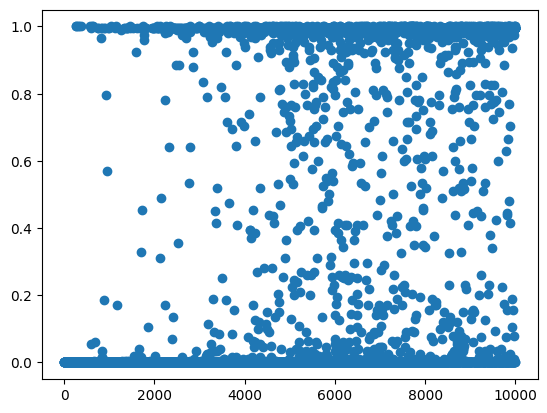

In [26]:
import matplotlib.pyplot as plt

plt.scatter(np.arange(len(curr_acc)), curr_acc)

In [30]:
def average_of_consecutive(lst, window_size=10):
    averages = []
    for i in range(0, len(lst), window_size):
        window = lst[i : i + window_size]
        if len(window) == window_size:
            averages.append(sum(window) / window_size)
    return averages


acc_adapted = average_of_consecutive(curr_acc, 100)

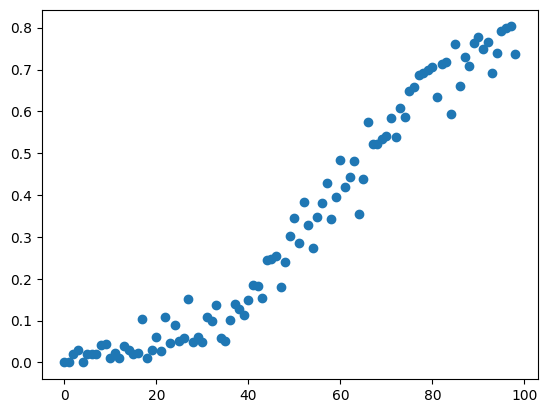

In [31]:
plt.scatter(np.arange(len(acc_adapted)), acc_adapted)

In [34]:
nested_dict = {
    "array1": np.array([1, 2, 3]),
    "array2": np.array([4, 5, 6]),
    "nested_dict2": {"array3": np.array([7, 8, 9]), "array4": np.array([10, 11, 12])},
}

# Save the nested dictionary with NumPy arrays
with open("nested_dict_arrays.pkl", "wb") as file:
    pickle.dump(nested_dict, file)

# Load the nested dictionary with NumPy arrays
with open("nested_dict_arrays.pkl", "rb") as file:
    loaded_nested_dict = pickle.load(file)

In [77]:
for i in range(50, 200 + 1, 50):
    if True:
        pass

In [84]:
for _, row in df_drugs.iterrows():
    for seq_length in range(50, 201, 50):
        if seq_length in test_set[row["perturbation"]]:
            valid_batch = test_set[row["perturbation"]][seq_length]
            seq_lengths = [seq_length] * len(valid_batch)
            padded_dataset, attention_masks = pad_dataset(
                jnp.asarray(valid_batch), seq_lengths, max_seq_length=model.max_seq_length
            )
            labels = [row["index"]] * len(valid_batch)
            assert False

(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50
(50, 2000) 50


AssertionError: 

In [83]:
def pad_dataset(dataset: List[jnp.ndarray], lengths: List[jnp.ndarray], max_seq_length: int, pad_token=0):
    padded_dataset = []
    attention_mask = []
    for data, length in zip(dataset, lengths):
        print(data.shape, length)
        pad_length = max_seq_length - length
        padded_data = jnp.pad(data, ((0, pad_length), (0, 0)), constant_values=pad_token)
        padded_data = padded_data[:max_seq_length]
        padded_dataset.append(padded_data)
        mask = jnp.array([1] * int(length) + [0] * int(pad_length))  # 1 no pad, 0 pad
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.array(padded_dataset), jnp.array(attention_mask)

In [82]:
jnp.asarray(valid_batch).shape

(10, 50, 2000)